In [5]:
# imports -- change ip and fingerprint between hosts
import pandas as pd
import pyexasol

host = '192.168.56.102/3885B5AFF646C6753863B5F188D201CE6D3CBF1C7F2DA42953E387837905BE65:8563'   # Don't forget to change the fingerprint
user = 'sys'
password = 'exasol'

# Connect to Exasol
conn = pyexasol.connect(dsn=host, 
                        user=user, 
                        password=password, 
                        debug=False, 
                        protocol_version=pyexasol.PROTOCOL_V1)

In [6]:
import time

# Start timing
start_time = time.time()

# Corrected SQL Query
Query='''
CREATE OR REPLACE TABLE AOL_SCHEMA.Weather_Reaction_Queries AS
WITH MonthLookup AS (
    SELECT 'january' AS month_name, '01' AS month_number
    UNION ALL
    SELECT 'february', '02'
    UNION ALL
    SELECT 'march', '03'
    UNION ALL
    SELECT 'april', '04'
    UNION ALL
    SELECT 'may', '05'
    UNION ALL
    SELECT 'june', '06'
    UNION ALL
    SELECT 'july', '07'
    UNION ALL
    SELECT 'august', '08'
    UNION ALL
    SELECT 'september', '09'
    UNION ALL
    SELECT 'october', '10'
    UNION ALL
    SELECT 'november', '11'
    UNION ALL
    SELECT 'december', '12'
),
TrimmedQuery AS (
    SELECT
        TRIM(LOWER(QUERYDIM."QUERY")) AS query_lower
    FROM AOL_SCHEMA."QUERYDIM"
),
PreparedData AS (
    SELECT 
        TIMEDIM."month",
        TIMEDIM."day of the month",
        TIMEDIM."hour",
        TIMEDIM."minute",
        QUERYDIM."QUERY",
        FACTS."ANONID",
        TO_TIMESTAMP(
            '2006-' || 
            COALESCE(MonthLookup.month_number, '00') || 
            '-' || 
            LPAD(CAST(TIMEDIM."day of the month" AS VARCHAR(10)), 2, '0') || 
            ' ' ||
            LPAD(CAST(TIMEDIM."hour" AS VARCHAR(2)), 2, '0') || ':' || 
            LPAD(CAST(TIMEDIM."minute" AS VARCHAR(2)), 2, '0')
        ) AS formatted_date,
        TRIM(LOWER(QUERYDIM."QUERY")) AS query_lower_trimmed
    FROM AOL_SCHEMA."TIMEDIM"
    INNER JOIN AOL_SCHEMA."QUERYDIM" ON QUERYDIM."ID" = TIMEDIM."ID"
    INNER JOIN AOL_SCHEMA."FACTS" ON FACTS."QUERYID" = QUERYDIM."ID"
    LEFT JOIN MonthLookup ON LOWER(TRIM(TIMEDIM."month")) = MonthLookup.month_name
    WHERE FACTS."CLICK" = 1
)
SELECT DISTINCT
    formatted_date,
    QUERY AS query_lower_trimmed,
    ANONID,
    CASE 
        WHEN query_lower_trimmed LIKE '%shelter%' 
             OR query_lower_trimmed LIKE '%safe%room%' 
             OR query_lower_trimmed LIKE '%temporary%housing%' 
             OR query_lower_trimmed LIKE '%housing%assistance%' THEN 'Shelter and Immediate Protection'
        
        WHEN query_lower_trimmed LIKE '%safety%' 
             OR query_lower_trimmed LIKE '%safe%' 
             OR query_lower_trimmed LIKE '%evacuation%' 
             OR query_lower_trimmed LIKE '%survival%' 
             OR query_lower_trimmed LIKE '%prepare%' 
             OR query_lower_trimmed LIKE '%first aid%' 
             OR query_lower_trimmed LIKE '%supplies%' 
             OR query_lower_trimmed LIKE '%warning%' 
             OR query_lower_trimmed LIKE '%emergency%' 
             OR query_lower_trimmed LIKE '%disaster%' 
             OR query_lower_trimmed LIKE '%alert%' 
             OR query_lower_trimmed LIKE '%tracker%' THEN 'Emergency Preparedness and Safety'

        WHEN query_lower_trimmed LIKE '%damage%' 
             OR query_lower_trimmed LIKE '%repair%'  
             OR query_lower_trimmed LIKE '%insurance%' THEN 'Damage Assessment and Recovery'
        
        WHEN query_lower_trimmed LIKE '%relief%'
             OR query_lower_trimmed LIKE '%volunteer%' 
             OR query_lower_trimmed LIKE '%donate%'
             OR query_lower_trimmed LIKE '%donation%'
             OR query_lower_trimmed LIKE '%fund%'
             OR query_lower_trimmed LIKE '%charity%'  THEN 'Relief and Support'
        
        WHEN query_lower_trimmed LIKE '%weather%' OR 
             query_lower_trimmed LIKE '%climate%' OR 
             query_lower_trimmed LIKE '%temperature%' OR 
             query_lower_trimmed LIKE 'rain%' OR 
             query_lower_trimmed LIKE '%snow%' OR 
             query_lower_trimmed LIKE '%wind' OR 
             query_lower_trimmed LIKE '%winds' OR 
             query_lower_trimmed LIKE '%storm%' OR 
             query_lower_trimmed LIKE '%hurricane%' OR 
             query_lower_trimmed LIKE '%tornado%' OR 
             query_lower_trimmed LIKE '%forecast%' OR 
             query_lower_trimmed LIKE '%meteorology%' OR 
             query_lower_trimmed LIKE '%atmosphere%' OR 
             query_lower_trimmed LIKE '%humidity%' OR 
             query_lower_trimmed LIKE '%precipitation%' OR 
             query_lower_trimmed LIKE '%heatwave%' OR 
             query_lower_trimmed LIKE '%drought%' OR 
             query_lower_trimmed LIKE '%cold%' OR 
             query_lower_trimmed LIKE '%blizzard%' OR 
             query_lower_trimmed LIKE '%hail%' OR 
             query_lower_trimmed LIKE '%thunder%' OR 
             query_lower_trimmed LIKE '%lightning%' OR 
             query_lower_trimmed LIKE '%fog%' OR 
             query_lower_trimmed LIKE '%frost%' OR 
             query_lower_trimmed LIKE '%sunny%' OR 
             query_lower_trimmed LIKE '%cloudy%' OR 
             query_lower_trimmed LIKE '%overcast%' OR
             query_lower_trimmed LIKE '%weather%radar%' THEN 'Weather Tracking and Alerts'
        ELSE 'Other'
    END AS QUERY_ABOUT
FROM PreparedData
WHERE (
        query_lower_trimmed LIKE '%shelter%' 
        OR query_lower_trimmed LIKE '%safety%' 
        OR query_lower_trimmed LIKE '%safe%' 
        OR query_lower_trimmed LIKE '%emergency%' 
        OR query_lower_trimmed LIKE '%tornado%' 
        OR query_lower_trimmed LIKE '%storm%' 
        OR query_lower_trimmed LIKE '%damage%' 
        OR query_lower_trimmed LIKE '%evacuation%' 
        OR query_lower_trimmed LIKE '%survival%' 
        OR query_lower_trimmed LIKE '%insurance%' 
        OR query_lower_trimmed LIKE '%repair%' 
        OR query_lower_trimmed LIKE '%fund%'
        OR query_lower_trimmed LIKE '%relief%' 
        OR query_lower_trimmed LIKE '%warning%' 
        OR query_lower_trimmed LIKE '%volunteer%' 
        OR query_lower_trimmed LIKE '%donate%' 
        OR query_lower_trimmed LIKE '%charity%' 
        OR query_lower_trimmed LIKE '%forecast%' 
        OR query_lower_trimmed LIKE '%weather%' 
        OR query_lower_trimmed LIKE '%alert%'
        OR query_lower_trimmed LIKE '%climate%' 
        OR query_lower_trimmed LIKE '%temperature%' 
        OR query_lower_trimmed LIKE 'rain%' 
        OR query_lower_trimmed LIKE '%weather%radar%' 
        OR query_lower_trimmed LIKE '%snow%' 
        OR query_lower_trimmed LIKE '%wind' 
        OR query_lower_trimmed LIKE '%winds' 
        OR query_lower_trimmed LIKE '%storm%'  
        OR query_lower_trimmed LIKE '%hurricane%' 
        OR query_lower_trimmed LIKE '%forecast%' 
        OR query_lower_trimmed LIKE '%meteorology%' 
        OR query_lower_trimmed LIKE '%atmosphere%' 
        OR query_lower_trimmed LIKE '%humidity%' 
        OR query_lower_trimmed LIKE '%precipitation%' 
        OR query_lower_trimmed LIKE '%heatwave%' 
        OR query_lower_trimmed LIKE '%drought%' 
        OR query_lower_trimmed LIKE '%cold%' 
        OR query_lower_trimmed LIKE '%blizzard%' 
        OR query_lower_trimmed LIKE '%hail%' 
        OR query_lower_trimmed LIKE '%thunder%' 
        OR query_lower_trimmed LIKE '%lightning%' 
        OR query_lower_trimmed LIKE '%fog%' 
        OR query_lower_trimmed LIKE '%frost%'
    )
'''

try:
    conn.execute(Query)
    # End timing
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total elapsed time: {elapsed_time:.2f} seconds")
except Exception as e:
    print(f"Error occurred: {e}")

Total elapsed time: 244.75 seconds


In [7]:
start_time = time.time()

QUERY = '''
SELECT *
FROM AOL_SCHEMA.Weather_Reaction_Queries
'''

# Execute the query and fetch results
query_events = conn.export_to_pandas(QUERY)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(query_events.head(3))
print(f"Total elapsed time: {elapsed_time:.2f} seconds")


               FORMATTED_DATE                 QUERY_LOWER_TRIMMED  ANONID  \
0  2006-04-24 14:02:00.000000  thundervalley speedway in michigan  583463   
1  2006-04-10 00:16:00.000000           how to donate bone marrow  121419   
2  2006-04-15 01:23:00.000000   colorado energy grants solar wind  179845   

                   QUERY_ABOUT  
0  Weather Tracking and Alerts  
1           Relief and Support  
2  Weather Tracking and Alerts  
Total elapsed time: 1.63 seconds


In [4]:
query_events.shape

(71331, 4)

In [5]:
query_events

,FORMATTED_DATE,QUERY_LOWER_TRIMMED,ANONID,QUERY_ABOUT
0,2006-04-24 14:02:00.000000,thundervalley speedway in michigan,583463,Weather Tracking and Alerts
1,2006-04-10 00:16:00.000000,how to donate bone marrow,121419,Relief and Support
2,2006-04-15 01:23:00.000000,colorado energy grants solar wind,179845,Weather Tracking and Alerts
3,2006-03-24 20:00:00.000000,power efficient hot water temperature,501133,Weather Tracking and Alerts
4,2006-03-21 14:15:00.000000,tn farm bureau auto insurance,312507,Damage Assessment and Recovery
...,...,...,...,...
71326,2006-03-23 08:18:00.000000,weather underground,143789,Weather Tracking and Alerts
71327,2006-03-19 00:55:00.000000,the weather channel.com,563696,Weather Tracking and Alerts
71328,2006-04-24 07:41:00.000000,tornado tools weed eater,206658,Weather Tracking and Alerts
71329,2006-04-20 14:08:00.000000,pontiac vibe repair help,564453,Damage Assessment and Recovery


## Original Tokeization Table

In [216]:
import time
import pandas as pd

# Start timing
start_time = time.time()

# Corrected SQL query
Query = '''
CREATE OR REPLACE TABLE AOL_SCHEMA.tokenization_new_queries AS
WITH WITH Queries_new AS (
SELECT DISTINCT
    TIMEDIM."month",
    TIMEDIM."day of the month",
    TIMEDIM."hour",
    TIMEDIM."minute",
    QUERYDIM."QUERY",
    FACTS."ANONID",
    TO_TIMESTAMP(
        '2006-' || 
        LPAD(
            CASE 
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'january' THEN '01'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'february' THEN '02'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'march' THEN '03'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'april' THEN '04'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'may' THEN '05'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'june' THEN '06'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'july' THEN '07'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'august' THEN '08'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'september' THEN '09'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'october' THEN '10'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'november' THEN '11'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'december' THEN '12'
                ELSE '00'
            END, 2, '0') || 
        '-' || 
        LPAD(CAST(TIMEDIM."day of the month" AS VARCHAR(2)), 2, '0') || 
        ' ' ||
        LPAD(CAST(TIMEDIM."hour" AS VARCHAR(2)), 2, '0') || ':' || 
        LPAD(CAST(TIMEDIM."minute" AS VARCHAR(2)), 2, '0')
    ) AS formatted_date
FROM AOL_SCHEMA."TIMEDIM"
INNER JOIN AOL_SCHEMA."QUERYDIM" ON QUERYDIM."ID" = TIMEDIM."ID"
INNER JOIN AOL_SCHEMA."FACTS" ON FACTS."QUERYID" = QUERYDIM."ID"
WHERE FACTS."CLICK" = 1
),
limited_querydim AS (
    SELECT DISTINCT QUERY
    FROM Queries_new
    WHERE QUERY IS NOT NULL
      AND NOT (LOWER(QUERY) LIKE '%com' OR LOWER(QUERY) LIKE '%net' 
      OR LOWER(QUERY) LIKE '%org' OR LOWER(QUERY)  LIKE 'http%' 
      OR LOWER(QUERY) LIKE 'www%') -- Exclude queries ending with '.com', '.net', '.org'
),
tokenized_query AS (
    SELECT 
        QUERY, 
        REGEXP_SUBSTR(
            REGEXP_REPLACE(QUERY, '[^[:alnum:] ]', ''),  -- Remove special characters, keeping only alphanumeric and spaces
            '[^0-9[:space:]]+',  -- Extract tokens (ignore numbers and extra spaces)
            1, 
            LEVEL
        ) AS TOKEN,
        LEVEL AS TOKEN_POSITION
    FROM limited_querydim
    CONNECT BY PRIOR QUERY = QUERY
           AND LEVEL <= LENGTH(REGEXP_REPLACE(QUERY, '[^ ]+', '')) + 1 -- Number of words in the query
           AND QUERY IS NOT NULL
           AND REGEXP_SUBSTR(
                REGEXP_REPLACE(QUERY, '[^[:alnum:] ]', ''),  -- Clean query string
                '[^0-9[:space:]]+',  -- Extract tokens
                1, 
                LEVEL
           ) IS NOT NULL
)
SELECT 
    QUERY, 
    TOKEN, 
    TOKEN_POSITION
FROM tokenized_query
WHERE TOKEN IS NOT NULL  -- Exclude NULL tokens
  AND TOKEN NOT IN ('the', 'and', 'is', 'in', 'to', 'for', 'on', 'of', 'or', 'no', 'what', 'with', 'http', 'com', 'how', 'www', 'you', 'our', 'from', 'las', 'all', 'who', 'where', 'when', 'why', 'whom', 'whose', 'which') -- Exclude common stopwords
  AND LENGTH(TOKEN) > 2  -- Exclude tokens shorter than 3 characters
ORDER BY QUERY, TOKEN_POSITION;
'''

# Execute the query and fetch results
try:
    conn.execute(Query)
    # End timing
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total elapsed time: {elapsed_time:.2f} seconds")
except Exception as e:
    print(f"Error occurred: {e}")

Total elapsed time: 1000.94 seconds


## Weather Reaction Tokenization Table

In [8]:
import time
import pandas as pd

# Start timing
start_time = time.time()

# Corrected SQL query
Query = '''
CREATE OR REPLACE TABLE AOL_SCHEMA.tokenization_weather_reaction AS
WITH limited_querydim AS (
    SELECT DISTINCT QUERY_LOWER_TRIMMED 
    FROM AOL_SCHEMA.Weather_Reaction_Queries
    WHERE QUERY_LOWER_TRIMMED IS NOT NULL
      AND NOT (QUERY_LOWER_TRIMMED LIKE '%com' OR  QUERY_LOWER_TRIMMED LIKE '%net' OR  QUERY_LOWER_TRIMMED LIKE '%org' OR  QUERY_LOWER_TRIMMED  LIKE 'http%' OR  QUERY_LOWER_TRIMMED LIKE 'www%') 
),
tokenized_query AS (
    SELECT 
        QUERY_LOWER_TRIMMED AS QUERY,  -- Fix: Use QUERY_LOWER_TRIMMED consistently
        REGEXP_SUBSTR(
            REGEXP_REPLACE(QUERY_LOWER_TRIMMED, '[^[:alnum:] ]', ''),  -- Clean the query
            '[^0-9[:space:]]+',  -- Extract tokens
            1, 
            LEVEL
        ) AS TOKEN,
        LEVEL AS TOKEN_POSITION
    FROM limited_querydim
    CONNECT BY PRIOR QUERY_LOWER_TRIMMED = QUERY_LOWER_TRIMMED  
           AND LEVEL <= LENGTH(REGEXP_REPLACE(QUERY_LOWER_TRIMMED, '[^ ]+', '')) + 1  -- Number of words
           AND QUERY_LOWER_TRIMMED IS NOT NULL
           AND REGEXP_SUBSTR(
                REGEXP_REPLACE(QUERY_LOWER_TRIMMED, '[^[:alnum:] ]', ''),  -- Clean query string
                '[^0-9[:space:]]+',  -- Extract tokens
                1, 
                LEVEL
           ) IS NOT NULL
)
SELECT 
    QUERY, 
    TOKEN, 
    TOKEN_POSITION
FROM tokenized_query
WHERE TOKEN IS NOT NULL  -- Exclude NULL tokens
  AND TOKEN NOT IN ('the', 'and', 'are', 'is', 'in', 'to', 'for', 'on', 'of', 'or', 'no', 'what', 'with', 'http', 'com', 'how', 'www', 'you', 'our', 'from', 'las', 'all', 'new', 'who', 'where', 'when', 'why', 'whom', 'whose', 'which') -- Exclude common stopwords
  AND LENGTH(TOKEN) > 2  -- Exclude tokens shorter than 3 characters
ORDER BY QUERY, TOKEN_POSITION;
'''

# Execute the query and fetch results
try:
    conn.execute(Query)
    # End timing
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total elapsed time: {elapsed_time:.2f} seconds")
except Exception as e:
    print(f"Error occurred: {e}")

Total elapsed time: 4.46 seconds


## During an event - Original

In [19]:
start_time = time.time()

QUERY = '''
WITH Events_DATA AS (
    SELECT
        we.EVENT_TYPE,
        we.BEGIN_DATE_TIME,
        we.END_DATE_TIME
    FROM AOL_SCHEMA.WEATHER_EVENTS we
    WHERE we.BEGIN_DATE_TIME >= '2006-03-01 00:01:00.000000' -- Filter the events with the required begin date
),
WeatherQueries AS (
    SELECT DISTINCT
        TIMEDIM."month",
        TIMEDIM."day of the month",
        TIMEDIM."hour",
        TIMEDIM."minute",
        QUERYDIM."QUERY",
        FACTS."ANONID",
        TO_TIMESTAMP(
            '2006-' || 
            LPAD(
                CASE 
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'january' THEN '01'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'february' THEN '02'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'march' THEN '03'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'april' THEN '04'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'may' THEN '05'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'june' THEN '06'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'july' THEN '07'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'august' THEN '08'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'september' THEN '09'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'october' THEN '10'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'november' THEN '11'
                    WHEN LOWER(TRIM(TIMEDIM."month")) = 'december' THEN '12'
                    ELSE '00'
                END, 2, '0') || 
            '-' || 
            LPAD(CAST(TIMEDIM."day of the month" AS VARCHAR), 2, '0') || 
            ' ' || 
            LPAD(CAST(TIMEDIM."hour" AS VARCHAR), 2, '0') || ':' || 
            LPAD(CAST(TIMEDIM."minute" AS VARCHAR), 2, '0')
        ) AS formatted_date
    FROM AOL_SCHEMA."TIMEDIM"
    INNER JOIN AOL_SCHEMA."QUERYDIM" ON QUERYDIM."ID" = TIMEDIM."ID"
    INNER JOIN AOL_SCHEMA."FACTS" ON FACTS."QUERYID" = QUERYDIM."ID"
    WHERE 
        FACTS."CLICK" = 1 
        AND (
            LOWER(QUERY) LIKE '%weather%' OR 
            LOWER(QUERY) LIKE '%climate%' OR 
            LOWER(QUERY) LIKE '%temperature%' OR 
            LOWER(QUERY) LIKE '%rain%' OR 
            LOWER(QUERY) LIKE '%snow%' OR 
            LOWER(QUERY) LIKE '%wind%' OR 
            LOWER(QUERY) LIKE '%winds%' OR 
            LOWER(QUERY) LIKE '%storm%' OR 
            LOWER(QUERY) LIKE '%hurricane%' OR 
            LOWER(QUERY) LIKE '%tornado%' OR 
            LOWER(QUERY) LIKE '%forecast%' OR 
            LOWER(QUERY) LIKE '%meteorology%' OR 
            LOWER(QUERY) LIKE '%atmosphere%' OR 
            LOWER(QUERY) LIKE '%humidity%' OR 
            LOWER(QUERY) LIKE '%precipitation%' OR 
            LOWER(QUERY) LIKE '%heatwave%' OR 
            LOWER(QUERY) LIKE '%drought%' OR 
            LOWER(QUERY) LIKE '%cold%' OR 
            LOWER(QUERY) LIKE '%blizzard%' OR 
            LOWER(QUERY) LIKE '%hail%' OR 
            LOWER(QUERY) LIKE '%thunder%' OR 
            LOWER(QUERY) LIKE '%lightning%' OR 
            LOWER(QUERY) LIKE '%fog%' OR 
            LOWER(QUERY) LIKE '%frost%' OR 
            LOWER(QUERY) LIKE '%sunny%' OR 
            LOWER(QUERY) LIKE '%cloudy%' OR 
            LOWER(QUERY) LIKE '%overcast%' OR 
            LOWER(QUERY) LIKE '%air pressure%'
        )
),
Relevant_Queries AS (
    SELECT
        QUERIES_WEATHER.QUERY,
        QUERIES_WEATHER.FORMATTED_DATE,
        we.EVENT_TYPE
    FROM Events_DATA we
    INNER JOIN WeatherQueries AS QUERIES_WEATHER
        ON QUERIES_WEATHER.formatted_date BETWEEN we.BEGIN_DATE_TIME AND we.END_DATE_TIME
),
Grouped_Results AS (
    SELECT 
        QUERY,
        EVENT_TYPE,
        COUNT(*) AS query_count
    FROM Relevant_Queries
    GROUP BY GROUPING SETS (
        (QUERY, EVENT_TYPE)
    )
),
Tokens_Queries AS (
    SELECT 
        token.TOKEN, 
        ex.QUERY, 
        ex.EVENT_TYPE, 
        ex.query_count
    FROM Grouped_Results ex
    INNER JOIN AOL_SCHEMA.tokenization_new_queries token 
        ON ex.QUERY = token.QUERY
)
SELECT 
    EVENT_TYPE, 
    TOKEN, 
    SUM(query_count) AS total_query_count,
    SUM(query_count) * 1.0 / SUM(SUM(query_count)) OVER (PARTITION BY EVENT_TYPE) AS token_ratio_within_event
FROM Tokens_Queries
GROUP BY EVENT_TYPE, TOKEN
ORDER BY token_ratio_within_event DESC, EVENT_TYPE;
'''

# Execute the query and fetch results
query_events = conn.export_to_pandas(QUERY)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(query_events.head(3))
print(f"Total elapsed time: {elapsed_time:.2f} seconds")


   EVENT_TYPE       TOKEN  TOTAL_QUERY_COUNT  TOKEN_RATIO_WITHIN_EVENT
0  Dust Devil        rome                  1                      0.25
1  Dust Devil  australias                  1                      0.25
2  Dust Devil     weather                  1                      0.25
Total elapsed time: 89.15 seconds


In [8]:
query_events.shape

(101525, 2)

In [11]:
import numpy as np
np.unique(query_events[query_events['QUERY_ABOUT']!='Other']['QUERY_ABOUT'])

array(['Damage Assessment and Recovery',
       'Emergency Preparedness and Safety', 'Relief and Support',
       'Shelter and Immediate Protection', 'Weather Tracking and Alerts'],
      dtype=object)

In [23]:
print("Any NaN in DataFrame:", query_events.isna().any().any())

Any NaN in DataFrame: False


In [21]:
query_events.to_csv('query_during_events.csv', index=False)

## During Event - Weather Reaction - Tornado

In [43]:
import time

start_time = time.time()

QUERY = '''
WITH Events_DATA AS (
    SELECT
        we.EVENT_TYPE,
        we.BEGIN_DATE_TIME,
        we.END_DATE_TIME
    FROM AOL_SCHEMA.WEATHER_EVENTS we
    WHERE we.BEGIN_DATE_TIME >= '2006-03-01 00:01:00.000000'  
      AND LOWER(we.EVENT_TYPE) LIKE 'tornado'  
),
Relevant_Queries AS (
    SELECT
        QUERIES_WEATHER.QUERY_LOWER_TRIMMED AS QUERY,
        QUERIES_WEATHER.FORMATTED_DATE,
        QUERIES_WEATHER.QUERY_ABOUT,
        we.EVENT_TYPE
    FROM Events_DATA we
    INNER JOIN AOL_SCHEMA.Weather_Reaction_Queries AS QUERIES_WEATHER
        ON QUERIES_WEATHER.FORMATTED_DATE BETWEEN we.BEGIN_DATE_TIME AND we.END_DATE_TIME
),
Grouped_Results AS (
    SELECT 
        QUERY,
        QUERY_ABOUT,
        EVENT_TYPE,
        COUNT(*) AS query_count
    FROM Relevant_Queries
    GROUP BY GROUPING SETS (
        (QUERY, QUERY_ABOUT, EVENT_TYPE),
        (QUERY,EVENT_TYPE)
    )
),
Tokens_Queries AS (
    SELECT 
        token.TOKEN, 
        ex.QUERY, 
        ex.QUERY_ABOUT,
        ex.EVENT_TYPE, 
        ex.query_count
    FROM Grouped_Results ex
    INNER JOIN AOL_SCHEMA.tokenization_weather_reaction token 
        ON ex.QUERY = token.QUERY
),
TOKEN_COUNT AS (
    SELECT 
        TOKEN, 
        COALESCE(QUERY_ABOUT, 'UNKNOWN') AS QUERY_ABOUT, -- Treat NULLs as 'UNKNOWN' for group by
        SUM(query_count) AS token_count
    FROM Tokens_Queries 
    GROUP BY TOKEN, QUERY_ABOUT
    HAVING SUM(query_count)>2
    ORDER BY token_count DESC
),
TOTAL_QUERY_COUNT AS (
    SELECT
        QUERY_ABOUT,
        SUM(token_count) AS total_query_count
    FROM TOKEN_COUNT
    GROUP BY QUERY_ABOUT
),
NORMALIZED_TOKEN_COUNT AS (
    SELECT 
        tc.TOKEN,
        tc.QUERY_ABOUT,
        tc.token_count,
        tqc.total_query_count,
        CASE 
            WHEN tc.QUERY_ABOUT = 'UNKNOWN' THEN 
                (tc.token_count * 1.0 / 
                 (SELECT SUM(token_count) FROM TOKEN_COUNT WHERE QUERY_ABOUT = 'UNKNOWN'))
            ELSE 
                (tc.token_count * 1.0 / tqc.total_query_count)
        END AS Group_Specific_Token_Probability
    FROM TOKEN_COUNT tc
    JOIN TOTAL_QUERY_COUNT tqc
        ON tc.QUERY_ABOUT = tqc.QUERY_ABOUT
)
SELECT 
    TOKEN,
    QUERY_ABOUT,
    token_count,
    total_query_count,
    Group_Specific_Token_Probability,
    Group_Specific_Token_Probability*100 AS Group_specific_Token_Percentage
FROM NORMALIZED_TOKEN_COUNT
ORDER BY QUERY_ABOUT,Group_Specific_Token_Probability DESC;
'''

# Execute the query and fetch results
query_events = conn.export_to_pandas(QUERY)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

# Print the first 3 rows of the result and the elapsed time
print(query_events.head(3))
print(f"Total elapsed time: {elapsed_time:.2f} seconds")


       TOKEN                     QUERY_ABOUT  TOKEN_COUNT  TOTAL_QUERY_COUNT  \
0  insurance  Damage Assessment and Recovery          282               1067   
1     repair  Damage Assessment and Recovery          110               1067   
2     health  Damage Assessment and Recovery           36               1067   

   GROUP_SPECIFIC_TOKEN_PROBABILITY  GROUP_SPECIFIC_TOKEN_PERCENTAGE  
0                          0.264292                        26.429241  
1                          0.103093                        10.309278  
2                          0.033739                         3.373946  
Total elapsed time: 4.19 seconds


In [44]:
query_events[query_events['QUERY_ABOUT']=='Weather Tracking and Alerts']

,TOKEN,QUERY_ABOUT,TOKEN_COUNT,TOTAL_QUERY_COUNT,GROUP_SPECIFIC_TOKEN_PROBABILITY,GROUP_SPECIFIC_TOKEN_PERCENTAGE
739,weather,Weather Tracking and Alerts,331,1981,0.167087,16.708733
740,bug,Weather Tracking and Alerts,67,1981,0.033821,3.382130
741,cold,Weather Tracking and Alerts,56,1981,0.028269,2.826855
742,temperature,Weather Tracking and Alerts,46,1981,0.023221,2.322060
743,hurricane,Weather Tracking and Alerts,43,1981,0.021706,2.170621
...,...,...,...,...,...,...
968,cheese,Weather Tracking and Alerts,3,1981,0.001514,0.151439
969,east,Weather Tracking and Alerts,3,1981,0.001514,0.151439
970,changes,Weather Tracking and Alerts,3,1981,0.001514,0.151439
971,handy,Weather Tracking and Alerts,3,1981,0.001514,0.151439


In [50]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources (if you haven't already)
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_token(token):
    return lemmatizer.lemmatize(token)

# Apply lemmatization to the 'TOKEN' column
query_events['LEMMATIZED_TOKEN'] = query_events['TOKEN'].apply(lemmatize_token)

query_result = query_events.groupby(
    ['QUERY_ABOUT', 'LEMMATIZED_TOKEN'], as_index=False
).agg({
    'GROUP_SPECIFIC_TOKEN_PROBABILITY': 'sum',
    'GROUP_SPECIFIC_TOKEN_PERCENTAGE': 'sum'
})
# Print the result
print(query_result)


                        QUERY_ABOUT LEMMATIZED_TOKEN  \
0    Damage Assessment and Recovery              aaa   
1    Damage Assessment and Recovery            aetna   
2    Damage Assessment and Recovery          america   
3    Damage Assessment and Recovery         american   
4    Damage Assessment and Recovery             auto   
..                              ...              ...   
927     Weather Tracking and Alerts            world   
928     Weather Tracking and Alerts      yellowstone   
929     Weather Tracking and Alerts             york   
930     Weather Tracking and Alerts            youth   
931     Weather Tracking and Alerts             zone   

     GROUP_SPECIFIC_TOKEN_PROBABILITY  GROUP_SPECIFIC_TOKEN_PERCENTAGE  
0                            0.003749                         0.374883  
1                            0.002812                         0.281162  
2                            0.002812                         0.281162  
3                            0.0046

[nltk_data] Downloading package wordnet to /home/naka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/naka/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [57]:
query_result.to_csv('../Data/query_events_during_tornado.csv')

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Path to save images
output_folder = "../Images/"
os.makedirs(output_folder, exist_ok=True)  # Create the base folder if it doesn't exist

# Function to sanitize event names for file saving
def sanitize_filename(filename):
    return filename.replace("/", "_").replace("\\", "_").replace(":", "_")

# Create a function to generate and save a word cloud for an event
def generate_wordcloud(data, event_type):
    sanitized_event = sanitize_filename(event_type)  # Sanitize the event type
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(data)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    # Save the word cloud image
    image_path = os.path.join(output_folder, f"{sanitized_event}_during_events.png")
    os.makedirs(os.path.dirname(image_path), exist_ok=True)  # Ensure directory exists
    plt.savefig(image_path, format='png', bbox_inches='tight')
    plt.close()  # Close the plot to avoid overlapping

# Generate word clouds for each event and save
nan_rows = query_result[query_result['QUERY_ABOUT']!='UNKOWN']
token_frequencies = nan_rows.set_index('LEMMATIZED_TOKEN')['GROUP_SPECIFIC_TOKEN_PROBABILITY'].to_dict()
generate_wordcloud(token_frequencies, 'Tornado')


/tmp/ipykernel_4420/1032861197.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_tokens = filtered_overlap.groupby('QUERY_ABOUT').apply(


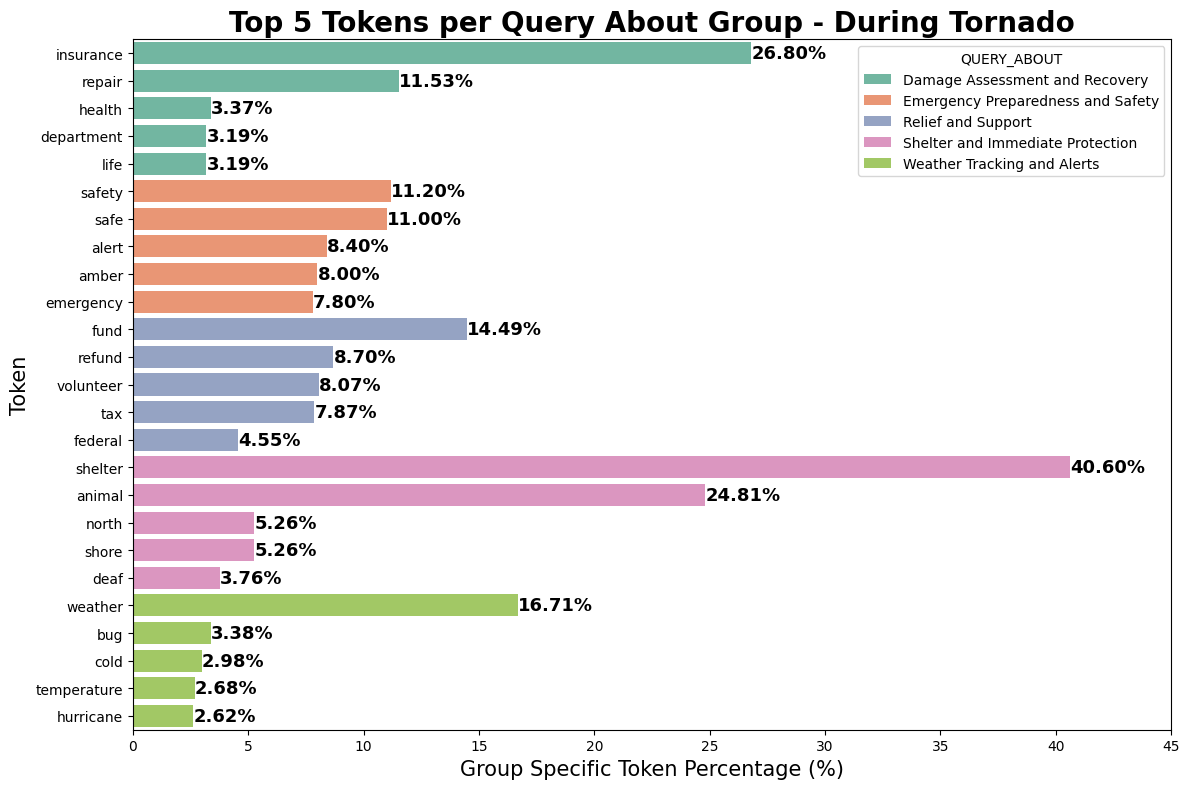

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

filtered_overlap = query_result[query_result['QUERY_ABOUT'] != 'UNKNOWN']

top_tokens = filtered_overlap.groupby('QUERY_ABOUT').apply(
    lambda x: x.nlargest(5, 'GROUP_SPECIFIC_TOKEN_PERCENTAGE')
).reset_index(drop=True)

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a bar plot where 'QUERY_ABOUT' is on the x-axis and 'GROUP_SPECIFIC_TOKEN_PROBABILITY' is on the y-axis
ax = sns.barplot(
    data=top_tokens,
    x='GROUP_SPECIFIC_TOKEN_PERCENTAGE',
    y='LEMMATIZED_TOKEN',
    hue='QUERY_ABOUT',  # Add color by 'QUERY_ABOUT'
    dodge=False,  # Makes sure bars for each QUERY_ABOUT are stacked rather than separate
    palette='Set2'  # You can choose any other color palette
)

# Set labels and title
plt.title('Top 5 Tokens per Query About Group - During Tornado', fontsize=20, fontweight='bold')
plt.xlabel('Group Specific Token Percentage (%)', fontsize=15)
plt.ylabel('Token', fontsize=15)

# Step 4: Annotate the bars with the probability values
for p in ax.patches:
    value = p.get_width()
    if value > 0:  # Only annotate if the value is greater than 0
        ax.annotate(
            f'{value:.2f}%',  # Format to show 2 decimal places
            (value, p.get_y() + p.get_height() / 2),  # Position of the text
            ha='left', va='center',  # Alignment of the text
            fontsize=13, color='black', fontweight='bold'
        )

plt.xticks(np.arange(0, 50, 5)) 
# Save the plot to the output folder
output_folder = "../Images/"
output_file = output_folder + "top_tokens_during_tornado.png"
plt.tight_layout()
plt.savefig(output_file)

# Display the plot
plt.tight_layout()
plt.show()


## Before After Torando - Original

In [313]:
import time

start_time = time.time()

QUERY = '''
WITH Queries_new AS (
SELECT DISTINCT
    TIMEDIM."month",
    TIMEDIM."day of the month",
    TIMEDIM."hour",
    TIMEDIM."minute",
    QUERYDIM."QUERY",
    FACTS."ANONID",
    TO_TIMESTAMP(
        '2006-' || 
        LPAD(
            CASE 
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'january' THEN '01'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'february' THEN '02'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'march' THEN '03'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'april' THEN '04'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'may' THEN '05'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'june' THEN '06'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'july' THEN '07'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'august' THEN '08'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'september' THEN '09'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'october' THEN '10'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'november' THEN '11'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'december' THEN '12'
                ELSE '00'
            END, 2, '0') || 
        '-' || 
        LPAD(CAST(TIMEDIM."day of the month" AS VARCHAR(2)), 2, '0') || 
        ' ' ||
        LPAD(CAST(TIMEDIM."hour" AS VARCHAR(2)), 2, '0') || ':' || 
        LPAD(CAST(TIMEDIM."minute" AS VARCHAR(2)), 2, '0')
    ) AS formatted_date
FROM AOL_SCHEMA."TIMEDIM"
INNER JOIN AOL_SCHEMA."QUERYDIM" ON QUERYDIM."ID" = TIMEDIM."ID"
INNER JOIN AOL_SCHEMA."FACTS" ON FACTS."QUERYID" = QUERYDIM."ID"
WHERE FACTS."CLICK" = 1
),
WeatherQueries AS (
    SELECT * 
    FROM Queries_new 
    WHERE
        LOWER(QUERY) LIKE '%weather%' OR 
        LOWER(QUERY) LIKE '%climate%' OR 
        LOWER(QUERY) LIKE '%temperature%' OR 
        LOWER(QUERY) LIKE '%rain%' OR 
        LOWER(QUERY) LIKE '%snow%' OR 
        LOWER(QUERY) LIKE '%wind%' OR 
        LOWER(QUERY) LIKE '%winds%' OR 
        LOWER(QUERY) LIKE '%storm%' OR 
        LOWER(QUERY) LIKE '%hurricane%' OR 
        LOWER(QUERY) LIKE '%tornado%' OR 
        LOWER(QUERY) LIKE '%forecast%' OR 
        LOWER(QUERY) LIKE '%meteorology%' OR 
        LOWER(QUERY) LIKE '%atmosphere%' OR 
        LOWER(QUERY) LIKE '%humidity%' OR 
        LOWER(QUERY) LIKE '%precipitation%' OR 
        LOWER(QUERY) LIKE '%heatwave%' OR 
        LOWER(QUERY) LIKE '%drought%' OR 
        LOWER(QUERY) LIKE '%cold%' OR 
        LOWER(QUERY) LIKE '%blizzard%' OR 
        LOWER(QUERY) LIKE '%hail%' OR 
        LOWER(QUERY) LIKE '%thunder%' OR 
        LOWER(QUERY) LIKE '%lightning%' OR 
        LOWER(QUERY) LIKE '%fog%' OR 
        LOWER(QUERY) LIKE '%frost%' OR 
        LOWER(QUERY) LIKE '%sunny%' OR 
        LOWER(QUERY) LIKE '%cloudy%' OR 
        LOWER(QUERY) LIKE '%overcast%' OR 
        LOWER(QUERY) LIKE '%air pressure%'
),
Events_DATA AS (
    -- Select tornado events with their start and end times, adjusting the window by -1 and +1 hour respectively
    SELECT DISTINCT
        we.EVENT_TYPE AS event_type,
        we.BEGIN_DATE_TIME,
        we.END_DATE_TIME,
        ADD_MINUTES(TO_TIMESTAMP(SUBSTR(we.BEGIN_DATE_TIME, 1, 19)), -5) AS WINDOW_START,
        ADD_MINUTES(TO_TIMESTAMP(SUBSTR(we.END_DATE_TIME, 1, 19)), 5) AS WINDOW_END
    FROM AOL_SCHEMA.WEATHER_EVENTS we
    WHERE LOWER(we.EVENT_TYPE) LIKE 'tornado'
),
Weather_Queries_TOR AS (
    -- Select weather queries where the query's formatted date is within the tornado event's window
    SELECT
        QUERIES_WEATHER.QUERY,
        QUERIES_WEATHER.FORMATTED_DATE,
        we.EVENT_TYPE,
        we.WINDOW_START,
        we.WINDOW_END
    FROM  Events_DATA we 
    INNER JOIN WeatherQueries QUERIES_WEATHER
        ON QUERIES_WEATHER.FORMATTED_DATE BETWEEN we.WINDOW_START AND we.WINDOW_END
),
Tornado_Queries AS (
    -- Select tornado events where their start and end times match the weather query times
    SELECT
        we.EVENT_TYPE,
        we.BEGIN_DATE_TIME,
        we.END_DATE_TIME,
        q.FORMATTED_DATE AS QUERY_DATE,
        we.WINDOW_START,
        we.WINDOW_END
    FROM Events_DATA we
    INNER JOIN Weather_Queries_TOR q
        ON q.FORMATTED_DATE BETWEEN we.BEGIN_DATE_TIME AND we.END_DATE_TIME
),
Relevant_Queries AS (
    -- Select all queries within the tornado event's window and classify as "Before" or "After"
    SELECT
        qt.QUERY,
        qt.FORMATTED_DATE,
        tq.EVENT_TYPE,
        tq.BEGIN_DATE_TIME,
        tq.END_DATE_TIME,
        tq.WINDOW_START,
        tq.WINDOW_END,
        CASE
            WHEN qt.FORMATTED_DATE < tq.BEGIN_DATE_TIME THEN 'Before'
            WHEN qt.FORMATTED_DATE > tq.END_DATE_TIME THEN 'After'
            ELSE NULL -- No need to handle the exact moment the tornado happens (we filter that out)
        END AS QUERY_RELATIVE_POSITION
    FROM Tornado_Queries tq
    INNER JOIN Queries_new qt 
        ON qt.FORMATTED_DATE BETWEEN tq.WINDOW_START AND tq.WINDOW_END
    WHERE qt.FORMATTED_DATE < tq.BEGIN_DATE_TIME
       OR qt.FORMATTED_DATE > tq.END_DATE_TIME
),
Grouped_Results AS (
    SELECT 
        QUERY,
        EVENT_TYPE,
        QUERY_RELATIVE_POSITION,
        COUNT(*) AS query_count
    FROM Relevant_Queries
    GROUP BY GROUPING SETS (
        (QUERY, EVENT_TYPE, QUERY_RELATIVE_POSITION)
    )
),
Tokens_Queries AS (
    SELECT 
        token.TOKEN, 
        ex.QUERY, 
        ex.EVENT_TYPE, 
        ex.QUERY_RELATIVE_POSITION,
        ex.query_count
    FROM Grouped_Results ex
    INNER JOIN AOL_SCHEMA.tokenization_new_queries token 
        ON ex.QUERY = token.QUERY
)
SELECT 
    EVENT_TYPE, 
    TOKEN, 
    QUERY_RELATIVE_POSITION,
    SUM(QUERY_COUNT) AS total_query_count,
    SUM(QUERY_COUNT) * 1.0 / 
    NULLIF(SUM(SUM(QUERY_COUNT)) OVER (PARTITION BY EVENT_TYPE, QUERY_RELATIVE_POSITION), 0) AS token_ratio_before_after_event
FROM Tokens_Queries
GROUP BY EVENT_TYPE, TOKEN, QUERY_RELATIVE_POSITION
ORDER BY token_ratio_before_after_event DESC
'''

# Execute the query to fetch data
query_events_af_bf = conn.export_to_pandas(QUERY)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total elapsed time: {elapsed_time:.2f} seconds")

# Print the tornado events that match the criteria
print(query_events_af_bf)


Total elapsed time: 325.45 seconds
      EVENT_TYPE              TOKEN QUERY_RELATIVE_POSITION  \
0        Tornado          sunbrella                   After   
1        Tornado               fart                   After   
2        Tornado           colorado                  Before   
3        Tornado                map                  Before   
4        Tornado          furniture                   After   
...          ...                ...                     ...   
11819    Tornado           response                   After   
11820    Tornado              honey                   After   
11821    Tornado  transgenderphotos                   After   
11822    Tornado         summercamp                   After   
11823    Tornado            imexsal                   After   

       TOTAL_QUERY_COUNT  TOKEN_RATIO_BEFORE_AFTER_EVENT  
0                   2952                        0.015373  
1                   2331                        0.012139  
2                   1794       

## After Tornado - User Reaction

In [61]:
import time

start_time = time.time()

QUERY = '''
WITH Ordered_Events AS (
    SELECT
        EVENT_TYPE,
        REGION,
        BEGIN_DATE_TIME,
        END_DATE_TIME,
        LEAD(BEGIN_DATE_TIME) OVER (ORDER BY BEGIN_DATE_TIME) AS NEXT_END_DATE_TIME
    FROM AOL_SCHEMA.WEATHER_EVENTS
    WHERE EVENT_TYPE = 'Tornado'
    ORDER BY BEGIN_DATE_TIME
),
Calculated_Events AS (
    SELECT
        EVENT_TYPE,
        BEGIN_DATE_TIME,
        END_DATE_TIME,
        ADD_MINUTES(TO_TIMESTAMP(SUBSTR(END_DATE_TIME, 1, 19)), 1) AS WINDOW_START,
        ADD_MINUTES(TO_TIMESTAMP(SUBSTR(NEXT_END_DATE_TIME, 1, 19)), -1) AS WINDOW_END
    FROM Ordered_Events
),
Window_Events AS (
    SELECT
        EVENT_TYPE,
        BEGIN_DATE_TIME,
        END_DATE_TIME,
        WINDOW_START,
        WINDOW_END
    FROM Calculated_Events
    WHERE SECONDS_BETWEEN(WINDOW_END, WINDOW_START) >= 0
),
Relevant_Queries AS (
    SELECT
        qt.QUERY_LOWER_TRIMMED AS QUERY,
        qt.QUERY_ABOUT,
        qt.FORMATTED_DATE,
        tq.EVENT_TYPE,
        tq.BEGIN_DATE_TIME,
        tq.END_DATE_TIME,
        tq.WINDOW_START,
        tq.WINDOW_END
    FROM Window_Events tq
    INNER JOIN AOL_SCHEMA.Weather_Reaction_Queries qt 
        ON qt.FORMATTED_DATE BETWEEN tq.WINDOW_START AND tq.WINDOW_END
),
Grouped_Results AS (
    SELECT 
        QUERY,
        EVENT_TYPE,
        QUERY_ABOUT,
        COUNT(*) AS query_count
    FROM Relevant_Queries
    GROUP BY GROUPING SETS (
        (QUERY, EVENT_TYPE, QUERY_ABOUT),
        (QUERY, EVENT_TYPE)
    )
),
Tokens_Queries AS (
    SELECT 
        token.TOKEN, 
        ex.EVENT_TYPE, 
        ex.QUERY_ABOUT,
        ex.query_count
    FROM Grouped_Results ex
    INNER JOIN AOL_SCHEMA.tokenization_new_queries token 
        ON ex.QUERY = token.QUERY
),
TOKEN_COUNT AS (
    SELECT 
        TOKEN, 
        COALESCE(QUERY_ABOUT, 'UNKNOWN') AS QUERY_ABOUT, -- Treat NULLs as 'UNKNOWN' for group by
        SUM(query_count) AS token_count
    FROM Tokens_Queries 
    GROUP BY TOKEN, QUERY_ABOUT
    HAVING SUM(query_count)>2
    ORDER BY token_count DESC
),
TOTAL_QUERY_COUNT AS (
    SELECT
        QUERY_ABOUT,
        SUM(token_count) AS total_token_count
    FROM TOKEN_COUNT
    GROUP BY QUERY_ABOUT
),
-- Normalize token probabilities for 'UNKNOWN' and other QUERY_ABOUT
NORMALIZED_TOKEN_COUNT AS (
    SELECT 
        tc.TOKEN,
        tc.QUERY_ABOUT,
        tc.token_count,
        tqc.total_token_count,  -- Correct column name
        CASE 
            WHEN tc.QUERY_ABOUT = 'UNKNOWN' THEN 
                (tc.token_count * 1.0 / 
                 (SELECT SUM(token_count) FROM TOKEN_COUNT WHERE QUERY_ABOUT = 'UNKNOWN'))
            ELSE 
                (tc.token_count * 1.0 / tqc.total_token_count)  -- Update here as well
        END AS Group_Specific_Token_Probability
    FROM TOKEN_COUNT tc
    JOIN TOTAL_QUERY_COUNT tqc
        ON tc.QUERY_ABOUT = tqc.QUERY_ABOUT
)
-- Final selection with normalized probabilities
SELECT 
    TOKEN,
    QUERY_ABOUT,
    token_count,
    total_token_count,
    Group_Specific_Token_Probability,
    Group_Specific_Token_Probability*100 AS Group_Specific_Token_Percentage
FROM NORMALIZED_TOKEN_COUNT
ORDER BY QUERY_ABOUT,Group_Specific_Token_Probability DESC;
'''

# Execute the query to fetch data
overlap = conn.export_to_pandas(QUERY)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total elapsed time: {elapsed_time:.2f} seconds")

# Print the tornado events that match the criteria
overlap


Total elapsed time: 18.33 seconds


,TOKEN,QUERY_ABOUT,TOKEN_COUNT,TOTAL_TOKEN_COUNT,GROUP_SPECIFIC_TOKEN_PROBABILITY,GROUP_SPECIFIC_TOKEN_PERCENTAGE
0,insurance,Damage Assessment and Recovery,9625,41534,0.231738,23.173785
1,repair,Damage Assessment and Recovery,3398,41534,0.081812,8.181249
2,health,Damage Assessment and Recovery,1198,41534,0.028844,2.884384
3,auto,Damage Assessment and Recovery,943,41534,0.022704,2.270429
4,life,Damage Assessment and Recovery,852,41534,0.020513,2.051331
...,...,...,...,...,...,...
13971,marco,Weather Tracking and Alerts,3,74301,0.000040,0.004038
13972,cooler,Weather Tracking and Alerts,3,74301,0.000040,0.004038
13973,straw,Weather Tracking and Alerts,3,74301,0.000040,0.004038
13974,brunswick,Weather Tracking and Alerts,3,74301,0.000040,0.004038


In [62]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources (if you haven't already)
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_token(token):
    return lemmatizer.lemmatize(token)

# Apply lemmatization to the 'TOKEN' column
overlap['LEMMATIZED_TOKEN'] = overlap['TOKEN'].apply(lemmatize_token)

# Group by 'QUERY_ABOUT' and 'LEMMATIZED_TOKEN', and sum 'GROUP_SPECIFIC_TOKEN_PROBABILITY'
result = overlap.groupby(
    ['QUERY_ABOUT', 'LEMMATIZED_TOKEN'], as_index=False
).agg({
    'GROUP_SPECIFIC_TOKEN_PROBABILITY': 'sum',
    'GROUP_SPECIFIC_TOKEN_PERCENTAGE': 'sum'
})
# Print the result
print(result)


                          QUERY_ABOUT LEMMATIZED_TOKEN  \
0      Damage Assessment and Recovery              aaa   
1      Damage Assessment and Recovery             aarp   
2      Damage Assessment and Recovery               ab   
3      Damage Assessment and Recovery        abdominal   
4      Damage Assessment and Recovery            about   
...                               ...              ...   
12525     Weather Tracking and Alerts          zealand   
12526     Weather Tracking and Alerts          zermatt   
12527     Weather Tracking and Alerts              zip   
12528     Weather Tracking and Alerts             zone   
12529     Weather Tracking and Alerts           zurich   

       GROUP_SPECIFIC_TOKEN_PROBABILITY  GROUP_SPECIFIC_TOKEN_PERCENTAGE  
0                              0.000674                         0.067415  
1                              0.001517                         0.151683  
2                              0.000120                         0.012038  
3  

[nltk_data] Downloading package wordnet to /home/naka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/naka/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [63]:
# Sort within each QUERY_ABOUT group by Group_Specific_Token_Probability
result = result.sort_values(by=['QUERY_ABOUT', 'GROUP_SPECIFIC_TOKEN_PROBABILITY'], ascending=False)

result.to_csv('../Data/query_events_after_tornado.csv')

In [64]:
query_result = query_result.sort_values(by=['QUERY_ABOUT', 'GROUP_SPECIFIC_TOKEN_PROBABILITY'], ascending=False)
query_result.to_csv('../Data/query_events_during_tornado.csv')

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Path to save images
output_folder = "../Images/"
os.makedirs(output_folder, exist_ok=True)  # Create the base folder if it doesn't exist

# Function to sanitize event names for file saving
def sanitize_filename(filename):
    return filename.replace("/", "_").replace("\\", "_").replace(":", "_")

# Create a function to generate and save a word cloud for an event
def generate_wordcloud(data, event_type):
    sanitized_event = sanitize_filename(event_type)  # Sanitize the event type
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(data)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    # Save the word cloud image
    image_path = os.path.join(output_folder, f"{sanitized_event}_after_events.png")
    os.makedirs(os.path.dirname(image_path), exist_ok=True)  # Ensure directory exists
    plt.savefig(image_path, format='png', bbox_inches='tight')
    plt.close()  # Close the plot to avoid overlapping

# Generate word clouds for each event and save
nan_rows = result[result['QUERY_ABOUT']=='UNKNOWN']
token_frequencies = nan_rows.set_index('LEMMATIZED_TOKEN')['GROUP_SPECIFIC_TOKEN_PROBABILITY'].to_dict()
generate_wordcloud(token_frequencies,'Tornado')


/tmp/ipykernel_4420/2102956978.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_tokens = filtered_overlap.groupby('QUERY_ABOUT').apply(


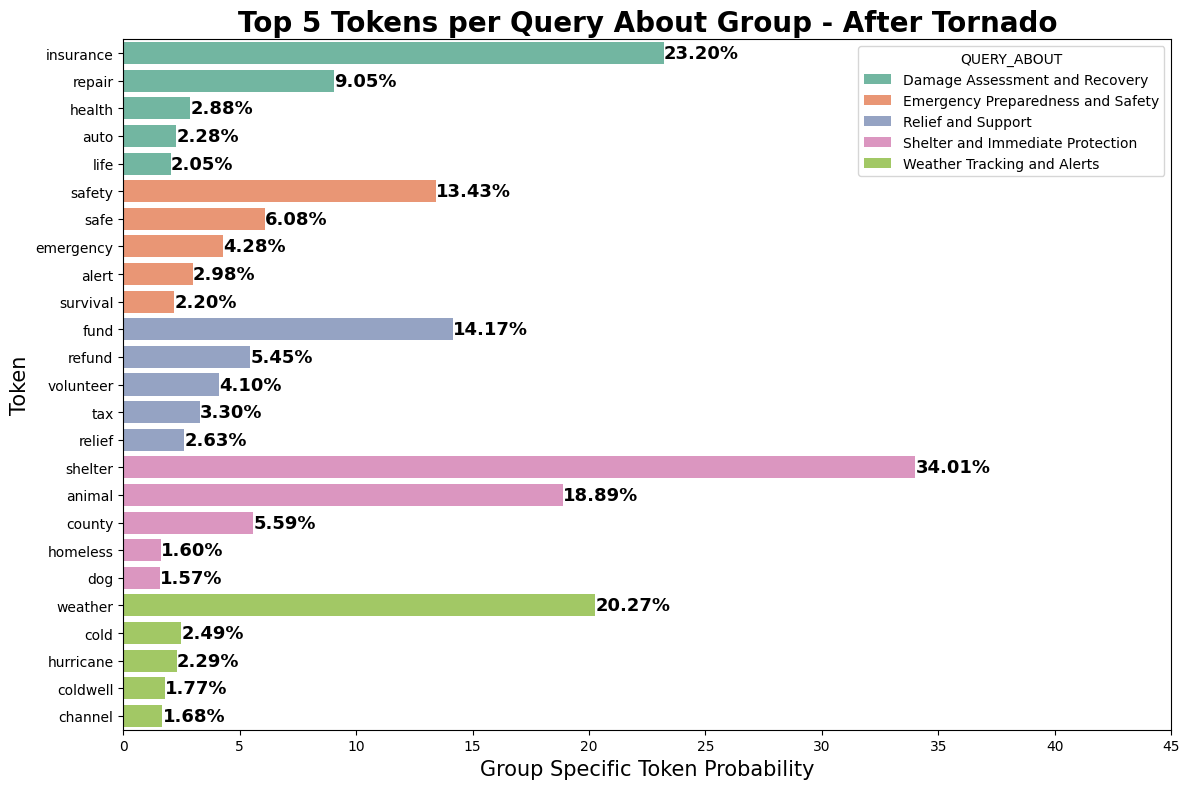

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

filtered_overlap = result[result['QUERY_ABOUT'] != 'UNKNOWN']

top_tokens = filtered_overlap.groupby('QUERY_ABOUT').apply(
    lambda x: x.nlargest(5, 'GROUP_SPECIFIC_TOKEN_PERCENTAGE')
).reset_index(drop=True)

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a bar plot where 'QUERY_ABOUT' is on the x-axis and 'GROUP_SPECIFIC_TOKEN_PROBABILITY' is on the y-axis
ax = sns.barplot(
    data=top_tokens,
    x='GROUP_SPECIFIC_TOKEN_PERCENTAGE',
    y='LEMMATIZED_TOKEN',
    hue='QUERY_ABOUT',  # Add color by 'QUERY_ABOUT'
    dodge=False,  # Makes sure bars for each QUERY_ABOUT are stacked rather than separate
    palette='Set2'  # You can choose any other color palette
)

# Set labels and title
plt.title('Top 5 Tokens per Query About Group - After Tornado', fontsize=20, fontweight='bold')
plt.xlabel('Group Specific Token Probability', fontsize=15)
plt.ylabel('Token', fontsize=15)

# Step 4: Annotate the bars with the probability values
for p in ax.patches:
    value = p.get_width()
    if value > 0:  # Only annotate if the value is greater than 0
        ax.annotate(
            f'{value:.2f}%',  # Format to show 2 decimal places
            (value, p.get_y() + p.get_height() / 2),  # Position of the text
            ha='left', va='center',  # Alignment of the text
            fontsize=13, color='black', fontweight='bold'
        )
        
plt.xticks(np.arange(0, 50, 5)) 
# Save the plot to the output folder
output_folder = "../Images/"
output_file = output_folder + "top_tokens_between_tornado.png"
plt.tight_layout()
plt.savefig(output_file)

# Display the plot
plt.tight_layout()
plt.show()
